In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import math
import time
import os
import matplotlib.pyplot as plt
import sys

In [2]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, transform=transformer, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transformer, download=True)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter =torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    test_iter =torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter
batch_size =256
train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=224)

0it [00:00, ?it/s]

26427392it [00:09, 2797983.61it/s]                              


Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 36387.64it/s]                           
0it [00:00, ?it/s]

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


4423680it [00:02, 1692872.99it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


8192it [00:00, 14686.27it/s]            

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw
Processing...
Done!


In [0]:
def train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr=None):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        net.train() # Switch to training mode
        n, start = 0, time.time()
        train_l_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        train_acc_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device) 
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
            % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

In [0]:
def evaluate_accuracy(data_iter, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Switch to evaluation mode for Dropout, BatchNorm etc layers.
    acc_sum, n = torch.tensor([0], dtype=torch.float32, device=device), 0
    for X, y in data_iter:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0]
    return acc_sum.item()/n

In [0]:
class Residual(nn.Module):
  
  def __init__(self,input_channels, num_channels, use_1x1conv=False, strides=1, **kwargs):
    super(Residual, self).__init__(**kwargs)
    self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, X):
    
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    Y =self.relu(Y)
    return Y

In [6]:

blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [0]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [0]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
b2=nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,2))
b4=nn.Sequential(*resnet_block(128,256,2))
b5=nn.Sequential(*resnet_block(256,512,2))
net=nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveMaxPool2d((1,1)),Flatten(),nn.Linear(512, 10))

In [10]:
lr, num_epochs, batch_size, device = 0.05, 5, 256,'cuda:0'
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr)

training on cuda:0
epoch 1, loss 0.0061, train acc 0.722, test acc 0.795, time 27.8 sec
epoch 2, loss 0.0014, train acc 0.864, test acc 0.808, time 27.7 sec
epoch 3, loss 0.0012, train acc 0.889, test acc 0.832, time 27.8 sec
epoch 4, loss 0.0010, train acc 0.908, test acc 0.858, time 27.8 sec
epoch 5, loss 0.0008, train acc 0.923, test acc 0.722, time 27.8 sec


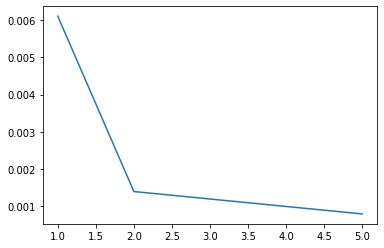

In [19]:
loss=[0.0061,0.0014,0.0012,0.0010,0.0008]
plt.plot([1,2,3,4,5],loss)

In [20]:
examples = enumerate(test_iter)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([256, 1, 96, 96])

In [0]:
with torch.no_grad():
  net.to('cpu')
  output = net(example_data)

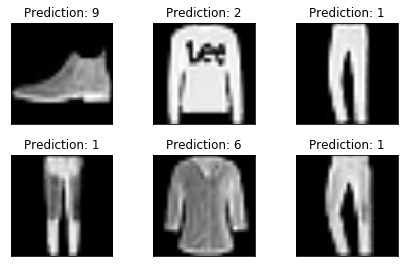

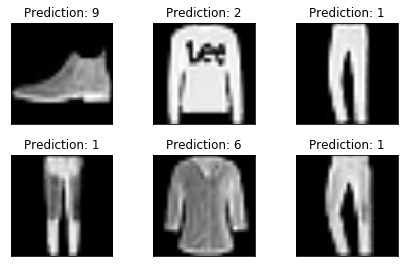

In [22]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig